In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots
%matplotlib inline

import sys
sys.path.append("/home/jonas/phd/NanoNets/src/")
import nanonets_utils

In [44]:
def rename_df_in_dic(dic):
    for key, df in dic.items():
        df.columns  = ['C1', 'I1', 'C2', 'I2', 'C3', 'C4', 'C5', 'O', 'G', 'Eq_Jumps', 'Jumps', 'Current', 'Error']
        df          = df[df['Jumps'] != 10000000.0]
        # df          = df[(df['Error']/df['Current']).abs().round(2) < np.inf]
        df          = nanonets_utils.prepare_for_fitness_calculation(df=df, N_c=5, min_current=0)
        dic[key]    = df
    return dic

def rename_df(df):
    df.columns  = ['C1', 'I1', 'C2', 'I2', 'C3', 'C4', 'C5', 'O', 'G', 'Eq_Jumps', 'Jumps', 'Current', 'Error']#
    df          = df[df['Jumps'] != 10000000.0]
    # df          = df[(df['Error']/df['Current']).abs().round(2) < np.inf]
    df          = nanonets_utils.prepare_for_fitness_calculation(df=df, N_c=5, min_current=0)
    return df

def combine_df_dic(df, dic, hue, hue_col):    
    for key, df_dic in dic.items():
        df_dic[hue_col] = hue
        df = pd.concat([df, df_dic], ignore_index=True)
    return df

In [45]:
R_vals              = [800, 6400]
df_base             = pd.read_csv("/home/jonas/phd/data/system_size/scaled/Nx=7_Ny=7_Nz=1_Ne=8.csv")
dic_resistance      = {f"R_{i}_{j}" : pd.read_csv(f"/home/jonas/phd/data/ndr_nls/resistance/R_{i}/Nx=7_Ny=7_Nz=1_Ne=8_s{j}.csv") for i in R_vals for j in range(4)}
dic_resistance_s    = {f"R_{i}" : pd.read_csv(f"/home/jonas/phd/data/ndr_nls/resistance/R_{i}_s/Nx=7_Ny=7_Nz=1_Ne=8.csv") for i in R_vals}
df_base             = rename_df(df_base)
dic_resistance      = rename_df_in_dic(dic_resistance)
dic_resistance_s    = rename_df_in_dic(dic_resistance_s)

In [46]:
fitness_base            = nanonets_utils.fitness(df=df_base, N_controls=5, delta=0)
fitness_resistance      = {i : nanonets_utils.fitness(df=df, N_controls=5, delta=0) for i, df in dic_resistance.items()}
fitness_resistance_s    = {i : nanonets_utils.fitness(df=df, N_controls=5, delta=0) for i, df in dic_resistance_s.items()}

In [47]:
fitness_base["dis"] = "standard"

df = fitness_base.copy()
df = combine_df_dic(df, fitness_resistance, "resistance", "dis")
df = combine_df_dic(df, fitness_resistance_s, "resistance_s", "dis")

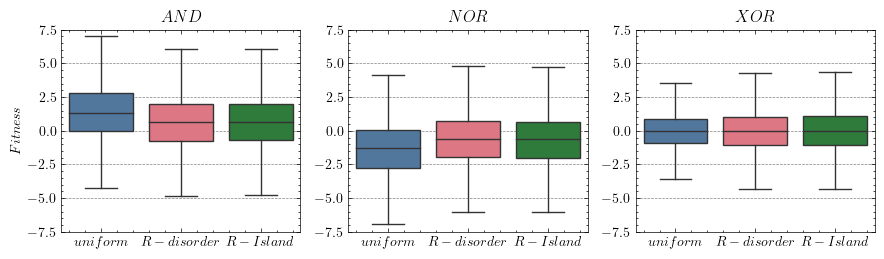

In [59]:
with plt.style.context(["science","bright","grid"]):

    fig = plt.figure()
    fig.set_figwidth(fig.get_figwidth()*3)

    for i, gate in enumerate(["AND","NOR","XOR"]):

        ax  = fig.add_subplot(1,3,i+1)
        ax  = sns.boxplot(data=df, x='dis', y=f'{gate} Fitness', ax=ax, fliersize=0)
        ax.set_xticklabels(["$uniform$","$R-disorder$","$R-Island$"], rotation=0)
        ax.set_xlabel("")

        if i == 0:
            ax.set_ylabel("$Fitness$")
        else:
            ax.set_ylabel("")

        ax.set_ylim(-7.5,7.5)
        ax.set_title(f"${gate}$")
    
    fig.savefig('plots/gate_fitness.svg', bbox_inches='tight', transparent=True)
    fig.savefig('plots/gate_fitness.pdf', bbox_inches='tight', transparent=False)

In [54]:
nls_base            = nanonets_utils.return_nls(nanonets_utils.nonlinear_parameter(df_base))
nls_resistance      = [nanonets_utils.return_nls(nanonets_utils.nonlinear_parameter(df)) for i, df in dic_resistance.items()]
nls_resistance_s    = [nanonets_utils.return_nls(nanonets_utils.nonlinear_parameter(df)) for i, df in dic_resistance_s.items()]
ndr_base            = nanonets_utils.return_ndr(pd.concat([nanonets_utils.nonlinear_parameter(df_base)['Ml'],nanonets_utils.nonlinear_parameter(df_base)['Mr']]).values)
ndr_resistance      = [nanonets_utils.return_ndr(pd.concat([nanonets_utils.nonlinear_parameter(df)['Ml'],nanonets_utils.nonlinear_parameter(df)['Mr']])) for i, df in dic_resistance.items()]
ndr_resistance_s    = [nanonets_utils.return_ndr(pd.concat([nanonets_utils.nonlinear_parameter(df)['Ml'],nanonets_utils.nonlinear_parameter(df)['Mr']])) for i, df in dic_resistance_s.items()]

/tmp/ipykernel_160812/2598772046.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["$uniform$","$r-disorder$","$r-Island$","$R-disorder$","$R-Island$"], rotation=0)


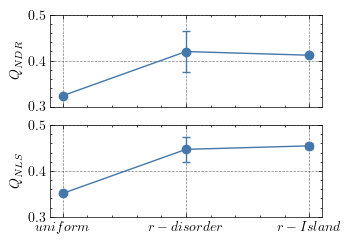

In [60]:
with plt.style.context(["science","bright","grid"]):

    fig = plt.figure()
    ax  = fig.add_subplot(2,1,1)
    
    ax.errorbar(["$uniform$","$R-disorder$","$R-Island$"],
                [ndr_base, np.mean(ndr_resistance), np.mean(ndr_resistance_s)],
                [0, np.std(ndr_resistance), np.std(ndr_resistance_s)],
                marker='o', capsize=3)
        
    ax.set_xticklabels("", rotation=20)
    ax.set_ylabel("$Q_{NDR}$")
    ax.set_ylim(0.3,0.5)

    ax  = fig.add_subplot(2,1,2)
    ax.errorbar(["$uniform$","$R-disorder$","$R-Island$"],
                [nls_base, np.mean(nls_resistance), np.mean(nls_resistance_s)],
                [0, np.std(nls_resistance), np.std(nls_resistance_s)],
                marker='o', capsize=3)
    ax.set_xticklabels(["$uniform$","$r-disorder$","$r-Island$","$R-disorder$","$R-Island$"], rotation=0)
    ax.set_ylabel("$Q_{NLS}$")
    ax.set_ylim(0.3,0.5)

    fig.savefig('plots/nonlinear_metrics.svg', bbox_inches='tight', transparent=True)
    fig.savefig('plots/nonlinear_metrics.pdf', bbox_inches='tight', transparent=False)

In [3]:
df_base                 = pd.read_csv("/home/jonas/phd/data/system_size/scaled/Nx=7_Ny=7_Nz=1_Ne=8.csv")
df_radius               = {i : pd.read_csv(f"/home/jonas/phd/data/disorder/radius/Nx=7_Ny=7_Nz=1_Ne=8_th={i}.csv") for i in range(36)}
df_radius_s_corr        = {i : pd.read_csv(f"/home/jonas/phd/data/disorder/radius_s_corr/Nx=7_Ny=7_Nz=1_Ne=8_th={i}.csv") for i in range(36)}
df_resistance           = {i : pd.read_csv(f"/home/jonas/phd/data/disorder/resistance/Nx=7_Ny=7_Nz=1_Ne=8_th={i}.csv") for i in range(36)}
df_resistance_s_corr    = {i : pd.read_csv(f"/home/jonas/phd/data/disorder/resistance_s_corr/Nx=7_Ny=7_Nz=1_Ne=8_th={i}.csv") for i in range(36)}

In [4]:
df_base                 = rename_df(df_base)
df_radius               = rename_df_in_dic(df_radius)
df_radius_s_corr        = rename_df_in_dic(df_radius_s_corr)
df_resistance           = rename_df_in_dic(df_resistance)
df_resistance_s_corr    = rename_df_in_dic(df_resistance_s_corr)

In [5]:
fitness_base                = nanonets_utils.fitness(df=df_base, N_controls=5, delta=0)
fitness_radius              = {i : nanonets_utils.fitness(df=df, N_controls=5, delta=0) for i, df in df_radius.items()}
fitness_radius_s_corr       = {i : nanonets_utils.fitness(df=df, N_controls=5, delta=0) for i, df in df_radius_s_corr.items()}
fitness_resistance          = {i : nanonets_utils.fitness(df=df, N_controls=5, delta=0) for i, df in df_resistance.items()}
fitness_resistance_s_corr   = {i : nanonets_utils.fitness(df=df, N_controls=5, delta=0) for i, df in df_resistance_s_corr.items()}

In [6]:
fitness_base["dis"] = "standard"

df = fitness_base.copy()
df = combine_df_dic(df, fitness_radius, "radius", "dis")
df = combine_df_dic(df, fitness_radius_s_corr, "radius_s_corr", "dis")
df = combine_df_dic(df, fitness_resistance, "resistance", "dis")
df = combine_df_dic(df, fitness_resistance_s_corr, "resistance_s_corr", "dis")

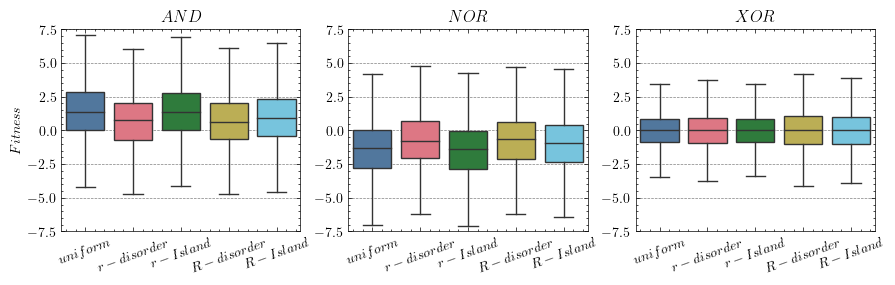

In [12]:
with plt.style.context(["science","bright","grid"]):

    fig = plt.figure()
    fig.set_figwidth(fig.get_figwidth()*3)

    for i, gate in enumerate(["AND","NOR","XOR"]):

        ax  = fig.add_subplot(1,3,i+1)
        ax  = sns.boxplot(data=df, x='dis', y=f'{gate} Fitness', ax=ax, fliersize=0)
        ax.set_xticklabels(["$uniform$","$r-disorder$","$r-Island$","$R-disorder$","$R-Island$"], rotation=20)
        ax.set_xlabel("")

        if i == 0:
            ax.set_ylabel("$Fitness$")
        else:
            ax.set_ylabel("")

        ax.set_ylim(-7.5,7.5)
        ax.set_title(f"${gate}$")
    
    fig.savefig('plots/gate_fitness.svg', bbox_inches='tight', transparent=True)
    fig.savefig('plots/gate_fitness.pdf', bbox_inches='tight', transparent=False)

In [8]:
ndr_base                = nanonets_utils.return_ndr(pd.concat([nanonets_utils.nonlinear_parameter(df_base)['Ml'],nanonets_utils.nonlinear_parameter(df_base)['Mr']]).values)
ndr_radius              = [nanonets_utils.return_ndr(pd.concat([nanonets_utils.nonlinear_parameter(df)['Ml'],nanonets_utils.nonlinear_parameter(df)['Mr']])) for i, df in df_radius.items()]
ndr_radius_s_corr       = [nanonets_utils.return_ndr(pd.concat([nanonets_utils.nonlinear_parameter(df)['Ml'],nanonets_utils.nonlinear_parameter(df)['Mr']])) for i, df in df_radius_s_corr.items()]
ndr_resistance          = [nanonets_utils.return_ndr(pd.concat([nanonets_utils.nonlinear_parameter(df)['Ml'],nanonets_utils.nonlinear_parameter(df)['Mr']])) for i, df in df_resistance.items()]
ndr_resistance_s_corr   = [nanonets_utils.return_ndr(pd.concat([nanonets_utils.nonlinear_parameter(df)['Ml'],nanonets_utils.nonlinear_parameter(df)['Mr']])) for i, df in df_resistance_s_corr.items()]

In [9]:
nls_base              = nanonets_utils.return_nls(nanonets_utils.nonlinear_parameter(df_base))
nls_radius            = [nanonets_utils.return_nls(nanonets_utils.nonlinear_parameter(df)) for i, df in df_radius.items()]
nls_radius_s_corr     = [nanonets_utils.return_nls(nanonets_utils.nonlinear_parameter(df)) for i, df in df_radius_s_corr.items()]
nls_resistance        = [nanonets_utils.return_nls(nanonets_utils.nonlinear_parameter(df)) for i, df in df_resistance.items()]
nls_resistance_s_corr = [nanonets_utils.return_nls(nanonets_utils.nonlinear_parameter(df)) for i, df in df_resistance_s_corr.items()]

/tmp/ipykernel_1770876/2490546418.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["$uniform$","$r-disorder$","$r-Island$","$R-disorder$","$R-Island$"], rotation=20)


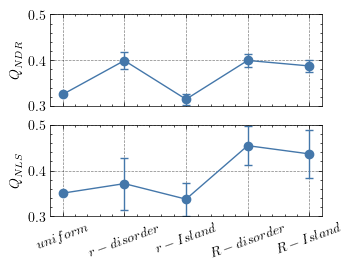

In [10]:
with plt.style.context(["science","bright","grid"]):

    fig = plt.figure()
    ax  = fig.add_subplot(2,1,1)
    
    ax.errorbar(["$uniform$","$r-disorder$","$r-Island$","$R-disorder$","$R-Island$"],
                [ndr_base, np.mean(ndr_radius), np.mean(ndr_radius_s_corr), np.mean(ndr_resistance), np.mean(ndr_resistance_s_corr)],
                [0, np.std(ndr_radius), np.std(ndr_radius_s_corr), np.std(ndr_resistance), np.std(ndr_resistance_s_corr)],
                marker='o', capsize=3)
        
    ax.set_xticklabels("", rotation=20)
    ax.set_ylabel("$Q_{NDR}$")
    ax.set_ylim(0.3,0.5)

    ax  = fig.add_subplot(2,1,2)
    ax.errorbar(["$uniform$","$r-disorder$","$r-Island$","$R-disorder$","$R-Island$"],
                [nls_base, np.mean(nls_radius), np.mean(nls_radius_s_corr), np.mean(nls_resistance), np.mean(nls_resistance_s_corr)],
                [0, np.std(nls_radius), np.std(nls_radius_s_corr), np.std(nls_resistance), np.std(nls_resistance_s_corr)],
                marker='o', capsize=3)
    ax.set_xticklabels(["$uniform$","$r-disorder$","$r-Island$","$R-disorder$","$R-Island$"], rotation=20)
    ax.set_ylabel("$Q_{NLS}$")
    ax.set_ylim(0.3,0.5)

    fig.savefig('plots/nonlinear_metrics.svg', bbox_inches='tight', transparent=True)
    fig.savefig('plots/nonlinear_metrics.pdf', bbox_inches='tight', transparent=False)